__[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)__

# A Comparison of Bandit Algorithms

## Multi-Armed Bandits: Part 6

![Photo by Jason Dent on Unsplash](https://cdn-images-1.medium.com/max/800/0*e7T9wQtgE2cro-mC)

Photo by __[Jason Dent](https://unsplash.com/@jdent?utm_source=medium&utm_medium=referral)__ on __[Unsplash](https://unsplash.com?utm_source=medium&utm_medium=referral)__

![](Images/green_babyrobot_small.gif)

# Overview

Over the course of this series we've looked at the framework and terminology that are used to define Multi-Armed Bandits. We then turned our attention to some of the algorithms that can be used to solve this problem, from the simple Greedy algorithms, up to the complex Bayesian approach of Thompson Sampling. Now there's only one question left to answer. Which of these approaches  is the best at solving the bandit problem?

---

For those not yet familiar with the Multi-Armed Bandit problem, or wishing to refresh their knowledge of any of the particular areas, the other parts in this series are as follows:


* __[Part 1: Mathematical Framework and Terminology](https://towardsdatascience.com/multi-armed-bandits-part-1-b8d33ab80697)__


* __[Part 2: The Bandit Framework](https://towardsdatascience.com/multi-armed-bandits-part-2-5834cb7aba4b)__


* __[Part 3: Bandit Algorithms](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18)__

    - [The Greedy Algorithm](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#d7a7)
    - [The Optimistic-Greedy Algorithm](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#1519)
    - [The Epsilon-Greedy Algorithm (ε-Greedy)](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#0145)
    - [Regret](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#b390)


* __[Part 4: The Upper Confidence Bound (UCB) Bandit Algorithm](https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f)__


* __[Part 5: Thompson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8)__
    - [Bernoulli Thompson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8#f535)
    - [Gaussian Thompson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8#16db)

# Recap

<i>Baby Robot is lost in the mall. Using Reinforcement Learning we want to help him find his way back to his mum. However, before he can even begin looking for her, he needs to recharge, from a set of power sockets that each give a slightly different amount of charge.</i>

<i>Using the strategies from the multi-armed bandit problem we need to find the best socket, in the shortest amount of time, to allow Baby Robot to get charged up and on his way.</i>

![](Images/power_socket.png)

<i>Baby Robot has entered a charging room containing 5 different power sockets. Each of these sockets returns a slightly different amount of charge. We want to get Baby Robot charged up in the minimum amount of time, so we need to locate the best socket and then use it until charging is complete.</i>
    
<i>This is identical to the Multi-Armed Bandit problem except that, instead of looking for a slot machine that gives the best payout, we're looking for a power socket that gives the most charge.</i>

---

# A Comparison of Bandit Algorithms

To answer the question of which is the best bandit algorithm (in terms of the ones we've looked at), we can re-frame the question in terms of our own problem: which algorithm will let Baby Robot get fully charged in the shortest amount of time?

To run this experiment we first need to define exactly what we mean by being fully charged. For this we'll just arbitrarily define that Baby Robot is fully charged when he has enough charge to run for an hour (3600 seconds).

With this definition we can now run each of our bandit algorithms for a maximum of 500 time steps to see how they get on.


For completeness we once again show all of the different Power Sockets that we'll be testing...

(<b>Note:</b> As in the other notebooks, the results shown below may not match exactly with those used in the descriptions. This is due to the random nature of the socket tests, so each run will be slightly different.)

In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

## The Standard Power Socket

In [2]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q):                
        self.q = q        # the true reward value              
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R
    
    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q

## The Optimistic Greedy Power Socket

In [3]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):    
                      
        # get the initial reqrd estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.) 
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
                
    def initialize(self):        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = self.initial_estimate    
        self.n = 0    

## The Upper Confidence Bounds Socket

In [4]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB socket """                  
        
        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)        
                
        # pass the true reward value to the base PowerSocket   
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

## The Gaussian Thompson Sampling Socket

In [5]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):                
                
        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0    
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """   

        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1       

## The Epsilon Greedy Socket Tester

Note that Epsilon Greedy just uses the standard power socket. 

Instead of cusomizing the power socket class it instead modifies the socket selection algorithm, to randomly select from the complete set of sockets when the probability value is less than the defined value of epsilon.

All other algorithms just use the standard socket selection routine, which always chooses the socket that returns the highest reward on the current time-step.

In [6]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, multiplier=2, epsilon = 0.2 ):  
        
        # create a standard socket tester
        super().__init__(socket_order=socket_order, multiplier=multiplier) 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""
        
        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
            socket_index = random_argmax([socket.sample(t) for socket in self.sockets])               
        
        return socket_index

## Testing on the standard power socket problem

In [7]:
methods = []
rewards = []
mean_rewards = []

def run_multiple_tests( tester, max_steps = 500, show_socket_percentages = True ):
    number_of_tests = 100
    number_of_steps = max_steps
    maximum_total_reward = 3600

    experiment = SocketExperiment(socket_tester   = tester,
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps,
                                  maximum_total_reward = maximum_total_reward)
    experiment.run()

    print(f'Mean Reward per Time Step = {experiment.get_mean_total_reward():0.3f}')
    print(f'Optimal Socket Selected = {experiment.get_optimal_selected():0.3f}')    
    print(f'Average Number of Trials Per Run = {experiment.get_mean_time_steps():0.3f}')
    if show_socket_percentages:
      print(f'Socket Percentages = {experiment.get_socket_percentages()}') 
        
    rewards.append(experiment.get_cumulative_reward_per_timestep())        
    mean_rewards.append(f"{experiment.get_mean_total_reward():0.3f}")

In [8]:
# Greedy Selection
run_multiple_tests( SocketTester( PowerSocket ) )

Mean Reward per Time Step = 7.895
Optimal Socket Selected = 0.160
Average Number of Trials Per Run = 424.880
Socket Percentages = [0.250 0.190 0.150 0.160 0.250]


In [9]:
# Epsilon Greedy
run_multiple_tests( EpsilonGreedySocketTester( epsilon = 0.2 ) )

Mean Reward per Time Step = 11.079
Optimal Socket Selected = 0.793
Average Number of Trials Per Run = 325.690
Socket Percentages = [0.044 0.044 0.049 0.793 0.070]


In [10]:
# Optimistic Greedy
run_multiple_tests( SocketTester( OptimisticSocket, initial_estimate = 20. ))

Mean Reward per Time Step = 11.959
Optimal Socket Selected = 0.976
Average Number of Trials Per Run = 301.610
Socket Percentages = [0.003 0.003 0.003 0.976 0.014]


In [11]:
# UCB
run_multiple_tests( SocketTester( UCBSocket, confidence_level = 0.6 ))

Mean Reward per Time Step = 11.968
Optimal Socket Selected = 0.985
Average Number of Trials Per Run = 301.340
Socket Percentages = [0.003 0.003 0.003 0.985 0.005]


In [12]:
# Thompson Sampling
run_multiple_tests( SocketTester( GaussianThompsonSocket ))

Mean Reward per Time Step = 12.050
Optimal Socket Selected = 1.000
Average Number of Trials Per Run = 299.240
Socket Percentages = [0.000 0.000 0.000 1.000 0.000]


| Algorithm | Mean Reward Per Timestep |
| --- | --- |
| Greedy | 7.684 |
| Epsilon Greedy | 11.055 |
| Optimistic Greedy | 11.987 |
| UCB | 11.965 |
| Thompson Sampling | 12.033 |

Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

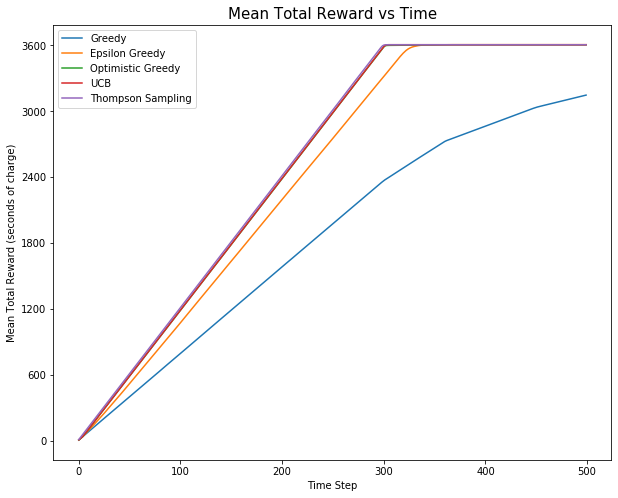

In [13]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

<i>Figure 6.1: A comparison of bandit algorithms on the 5-socket power problem.</i>



From the graph above we can see that:

* Optimistic Greedy, UCB and Thompson Sampling all reach the maximum required charge in approximately the same number of time steps (which is why the lines for Optimistic Greedy and Thompson Sampling are obscured by that for UCB).


* In each case, the regret for these algorithms is nearly zero. Each has taken only 300 time steps to reach the maximum required charge of 3600 seconds of charge, when the maximum available charge from any socket is 12 seconds of charge. So the optimal socket has been located quickly and then exploited to the full.


* Epsilon Greedy on the other hand takes slightly longer to reach maximum charge. Since it continues to explore the set of sockets throughout the run it fails to fully exploit the best socket.


* And, worst of all, is the Greedy algorithm. It actually fails to reach the maximum charge in the time available.


So, from the point of view of charging Baby Robot, any of the Optimistic Greedy, UCB or Thompson Sampling algorithms would do the job. However, it should be noted that both Optimistic Greedy and UCB require a parameter to be set (these parametes are the initial values for Optimistic Greedy and the confidence value for UCB). Making a bad choice for these parameters could lead to a degraded performance of the algorithm. 

Since Thompson Sampling doesn't require a parameter to be set, this isn't an issue, and so this may be the deciding factor when choosing which algorithm to use.

---

# Increasing the Problem Difficulty

The socket problem we've used up to now was deliberately made very simple, to allow the exploration and exploitation mechanisms of each algorithm to be illustrated. However, in terms of finding which algorithm is best, it has a couple of major drawbacks.


* Firstly, it only has five sockets. Therefore, even with the random search of the Greedy algorithm, there's a 20% chance of finding the best socket. For the more advanced search mechanisms they can quickly locate and lock onto the best socket since there are so few to test.


* Secondly, each socket has a very distinct reward. Since we setup the experiment with the sockets having a spacing of 2 seconds of charge and a unit variance in their reward, there is very little overlap in the amount of charge returned by a socket and the next best socket. Once the best socket has been tried once, it is very unlikely that any of the other sockets will return a charge that is greater than this value, making it very easy to identify which socket is optimal.


To overcome these deficiencies in our original experiment, let's double the number of sockets and decrease the difference in the amount of charge the sockets can return, reducing this from 2 seconds of charge down to 0.2. With these values the output of the sockets now looks as follows:

In [14]:
NUM_SOCKETS = 10

# using a fixed ordering for consistency
socket_order = [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]

print(f"Socket Order: {socket_order}")

MULTIPLIER = 0.2

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*MULTIPLIER)+2) for q in socket_order]

# iterate through each of the sockets
# - rewards will contain the charge returned at all of the time steps for each socket 
# - using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))
for socket_number,socket in enumerate(sockets):    
    # get charge from the socket for the defined number of steps   
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()      

Socket Order: [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]


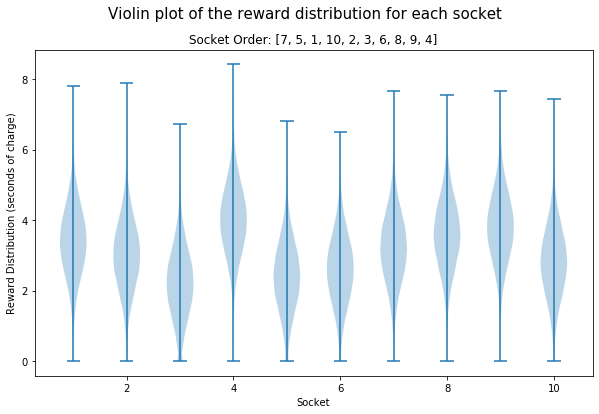

In [15]:
# plot the charge we got from the sockets    
plt.figure(figsize=(10,6))
plt.violinplot(rewards)   
plt.suptitle('Violin plot of the reward distribution for each socket', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.show() 

<i>Figure 6.2: The reward distribution of 10 sockets. The socket order defines the relative goodness of the sockets, from lowest to highest output. So socket 1 has the 7th highest output, socket 2 the 5th highest, etc.</i>

Text(0, 0.5, 'Density')

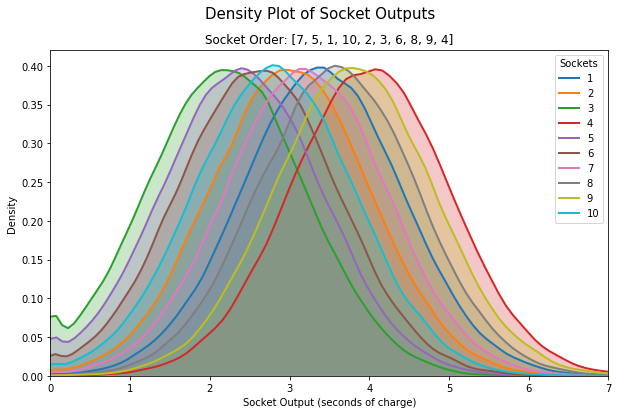

In [16]:
plt.figure(figsize=(10,6))

for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');
    
# Plot formatting
plt.xlim(0, 7)
plt.legend(title = 'Sockets')
plt.suptitle('Density Plot of Socket Outputs', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')

<i>Figure 6.3: The density plot of socket outputs. Socket 4 gives the highest mean output and socket 3 the least.</i>



Now we have 10 sockets, with 0.2 seconds of charge difference between the mean reward of a socket and the next best socket. This means that there's a much greater overlap in the rewards that are returned.

The socket order [7, 5, 1, 10, 2, 3, 6, 8, 9, 4] defines how good a socket is, in increasing order, so socket number 1 is the 7th best socket and will have a mean reward of (7 * 0.2 + 2) = 3.4 seconds of charge (the +2 is just an offset value to stop sockets from having negative values). So the best socket is socket 4, having a mean reward of (10 * 0.2 + 2) = 4 and the worst is socket 3, with a mean reward of (1 * 0.2 + 2) = 2.2.

A couple of other points to note are:

* Because we've reduced the spread in the mean values of the sockets, the best socket now has a lower output than when we only tested with 5 sockets. As a result, the number of time steps required to reach our defined maximum total reward, of 3600 seconds of charge, will be increased.


* We've kept the same parameters as in the 5 socket experiment for the UCB and Optimistic Greedy algorithms, so it's possible that tuning these values could give better results.


Running with this new setup generates the following results:

In [17]:
rewards = []

def run_tests( tester, max_steps = 1000 ): 
    run_multiple_tests( tester, max_steps = max_steps )

In [18]:
# Greedy Selection
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER ) )

Mean Reward per Time Step = 3.061
Optimal Socket Selected = 0.090
Average Number of Trials Per Run = 982.890
Socket Percentages = [0.060 0.080 0.130 0.090 0.110 0.080 0.080 0.090 0.130 0.150]


In [19]:
# Epsilon Greedy
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))

Mean Reward per Time Step = 3.768
Optimal Socket Selected = 0.626
Average Number of Trials Per Run = 956.110
Socket Percentages = [0.027 0.022 0.021 0.626 0.021 0.023 0.024 0.057 0.157 0.022]


In [20]:
# Optimistic Greedy
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))

Mean Reward per Time Step = 3.847
Optimal Socket Selected = 0.558
Average Number of Trials Per Run = 932.010
Socket Percentages = [0.054 0.011 0.001 0.558 0.001 0.001 0.012 0.096 0.264 0.002]


In [21]:
# UCB
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 ))

Mean Reward per Time Step = 3.937
Optimal Socket Selected = 0.817
Average Number of Trials Per Run = 915.210
Socket Percentages = [0.012 0.004 0.002 0.817 0.002 0.002 0.005 0.045 0.107 0.003]


In [22]:
# Thompson Sampling
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 4.000
Optimal Socket Selected = 0.993
Average Number of Trials Per Run = 900.500
Socket Percentages = [0.000 0.000 0.000 0.993 0.000 0.000 0.001 0.001 0.005 0.000]


| Algorithm | Mean Reward Per Timestep |
| --- | --- |
| Greedy | 3.003 |
| Epsilon Greedy | 3.757 |
| Optimistic Greedy | 3.872 |
| UCB | 3.931 |
| Thompson Sampling | 3.998 |

Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

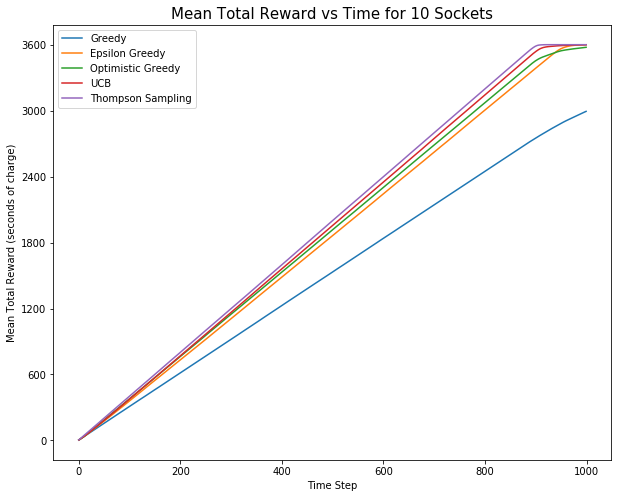

In [23]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time for 10 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

<i>Figure 6.4: A comparison of bandit algorithms on the 10-socket power problem, with a spread of 0.2 seconds of charge.</i>



Now we can see some separation in the performance of the algorithms:

* As before, the Greedy algorithm performs much worse than all the others. Epsilon Greedy, while being much better than the simple Greedy algorithm, is still worse than the other 3 algorithms.

* Although there's not a lot in it, Thompson Sampling clearly outperforms the others. 


This difference in the algorithms becomes even more distinct as the number of sockets is increased and the spread of mean reward values is decreased, as shown below, for 100 sockets with a spread of 0.1
(note that the maximum socket output is once again 12 
(= 0.1 * 100 + 2)):

In [24]:
# create the specified number of sockets in a random order 
NUM_SOCKETS = 100
socket_order = random.sample(range(1,1+NUM_SOCKETS), NUM_SOCKETS)

MULTIPLIER = 0.1

rewards = []

def run_tests( tester, max_steps = 300 ): 
    run_multiple_tests( tester, max_steps = max_steps, show_socket_percentages = False )              

In [25]:
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER )) 

Mean Reward per Time Step = 6.771
Optimal Socket Selected = 0.010
Average Number of Trials Per Run = 299.000


In [26]:
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))

Mean Reward per Time Step = 10.459
Optimal Socket Selected = 0.004
Average Number of Trials Per Run = 299.000


In [27]:
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))  

Mean Reward per Time Step = 10.284
Optimal Socket Selected = 0.004
Average Number of Trials Per Run = 299.000


In [28]:
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 )) 

Mean Reward per Time Step = 10.232
Optimal Socket Selected = 0.004
Average Number of Trials Per Run = 299.000


In [29]:
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER )) 

Mean Reward per Time Step = 12.003
Optimal Socket Selected = 0.000
Average Number of Trials Per Run = 298.760


| Algorithm | Mean Reward Per Timestep |
| --- | --- |
| Greedy | 6.818 |
| Epsilon Greedy | 10.558 |
| Optimistic Greedy | 10.250 |
| UCB | 10.224 |
| Thompson Sampling | 12.003 |

Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

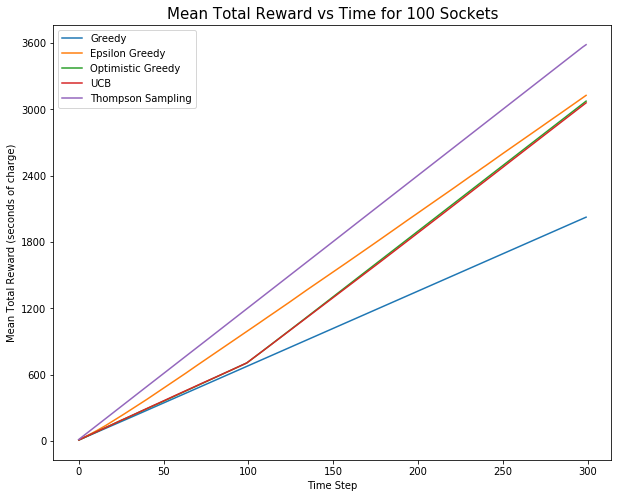

In [30]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time for 100 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

<i>Figure 6.5: A comparison of bandit algorithms on the 100-socket power problem, with a spread of 0.1 seconds of charge.</i>



With 100 sockets it's interesting to note how both the UCB and Optimistic Greedy algorithms perform worse than the Epsilon Greedy algorithm. In fact, by the time that Thompson Sampling has reached maximum charge, neither of these other algorithms has yet surpassed the total mean reward of Epsilon Greedy. 

This can be seen to be caused by the priming rounds of the UCB and Optimistic Greedy algorithms, during which each socket is tested exactly once (note the lower gradient up to the 100th time step). So, for the first 100 time steps, UCB and Optimistic Greedy are working their way through each of the 100 sockets, whereas Epsilon Greedy and Thompson Sampling have already started to exploit the best sockets that they've found.

If we left the experiment to run longer then UCB and Optimistic Greedy would probably exceed the mean total reward of Epsilon Greedy and reach full charge first. However, if Baby Robot has chosen his sockets using the Thompson Sampling algorithm he'll already be fully charged and already be on his way.

---

# Contextual Bandits

One major drawback of the basic bandit algorithms we've seen is that they take no account of any available context information.

For example, imagine that the power sockets were colour coded, with the colour giving an indication of the amount of charge that would be returned. If, after completing our trials, we found that blue sockets gave a lot of charge and yellow sockets gave very little, then it would make sense the next time we entered a charging station to favour blue sockets over yellow ones.

The basic bandit algorithms simply take an action, collect a reward, and pay no attention to their current state. Therefore potentially helpful information from the current state, that could assist in choosing the best action, is simply ignored.

Contextual bandits³ (also known as "associative bandits") address this limitation by using information from the current state to help guide their choice of action. As a result they can either be thought of as sophisticated bandit algorithms or as a simplified version of reinforcement learning.

In the full reinforcement learning problem the action that is taken can lead to a change in state and therefore to new contextual information. As a result, the chosen action can have an impact on the future rewards that can be obtained. For example, in a game of chess, a move that looks good and that gives a large immediate reward (such as taking the opposition's queen) may in fact lead to you losing the game. It would therefore actually be considered to be a bad move. The true reward is delayed and isn't received until the game ends.

In contextual bandits neither of these conditions exist; actions don't change the state and rewards are instant, not delayed.

---

# Uses of Bandit Algorithms

So, apart from charging Baby Robots or winning your fortune on the slot machines the next time you're in Vegas¹, what exactly can Multi-Armed Bandit algorithms be used for?

(<i>¹Disclaimer: Vegas casino owners are notoriously touchy about people using algorithms in their casinos. I therefore accept no responsibility for any damages, physical or financial, incurred during the use of these algorithms!</i>)

There are probably two main areas of use for Multi-Armed Bandits:

The first is how we've used them, as a stepping stone to full Reinforcement Learning. Many of the concepts, such as actions and rewards, from Multi-Armed Bandits are directly applicable to the full Reinforcement Learning (RL) problem. Effectively a Multi-Armed Bandit can be thought of as representing a single state in full Reinforcement Learning. Additionally, the greedy selection of actions, although maybe not the best approach to solving the bandit problem, is often used to choose between different actions in RL.

The second main area of use for bandit algorithms is during real world testing. This can be in any field but is particularly prevalent in online commerce, healthcare and finance.

For example, when assessing how changes to a web page affect its performance, where this can be measured in a variety of ways such as the sales generated from the page or the click through rate, a standard approach is to use A/B Testing. This takes two or more different variations of the page and then typically presents each of these equally to the site users to see how they perform. After a predefined period of time the statistics from each of the pages are compared and the one that has performed the best is then adopted as the winning page.

Quite clearly there is one major drawback to this form of testing: for the duration of the trial an equal number of customers are being sent to an under performing web page. If this page is performing particularly badly it could have a potentially large negative impact on your site's performance. By having a period solely dedicated to exploration A/B Testing continues to investigate badly performing options. 

In contrast, in a Multi-Armed Bandit approach, pages are presented to users according to their measured relative performances. Pages that are performing well will increasingly be shown and those that are under-performing will be shown less often. In this way changes to a website may be tested. Good features, that improve performance, are instantly promoted to give a positive impact and bad features, that in A/B testing would continue to give a negative impact for the duration of the test period, are quickly dropped.

Multi-Armed Bandits are used in a similar way in clinical trials. Obviously, during a drug trial, it would be a bad idea to continue to administer a drug that is causing patients to exhibit negative side effects. Therefore Multi-Armed Bandit algorithms have been employed to decide on the drugs and dosages to give to patients to maximise positive outcomes.


For a more comprehensive look at the practical uses of Bandit Algorithms I recommend checking out the following paper:


"[A Survey on Practical Applications of Multi-Armed and Contextual Bandits](https://arxiv.org/pdf/1904.10040.pdf)", 
Djallel Bouneffouf, Irina Rish (2019)

---

# Conclusion

We've seen that, when faced with the problem of having to choose between various different options, where the reward for selecting any of those options is initially unknown, that algorithms such as Thompson Sampling or Upper Confidence Bounds (UCB) perform much better than simply choosing from the options at random. With these algorithms we can minimise the number of times we try bad actions and maximise the number of times we take the best action.

By employing these algorithms in the socket selection problem we were able to quickly locate and exploit the best socket and get Baby Robot charged up and on his way.

In subsequent articles we'll look at more advanced Reinforcement Learning (RL) techniques, some of which make use of these bandit algorithms. Using these we'll help Baby Robot to find his way back to his mum!


---

<b>Note:</b> Although we've examined quite a few methods to solve the Multi-Armed Bandit problem, we've really just scratched the surface in terms of all available algorithms. Take a look at the __[Bandit Book](https://tor-lattimore.com/downloads/book/book.pdf)__ if you'd like to see a whole lot more.

---

![](Images/green_babyrobot_small.gif)

# References:

[1] "[Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/RLbook2020.pdf)", Sutton & Barto (2018)

[2] "[A Tutorial on Thompson Sampling](https://arxiv.org/abs/1707.02038)", Russo et al., (2017)

[3] "[A Contextual Bandit Bake-off](https://arxiv.org/abs/1802.04064)", Bietti et al., (2020)

[4] "[A Survey on Practical Applications of Multi-Armed and Contextual Bandits](https://arxiv.org/pdf/1904.10040.pdf)", Djallel Bouneffouf, Irina Rish (2019)